In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
from data_processing import *
from sklearn.metrics import mean_absolute_error, r2_score,mean_squared_error
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import optuna

import numpy as np
from tqdm import tqdm
import copy
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [2]:
### Load data
data_dir = "../01_Datenaufbereitung/Output/Calculated/"
all_data = load_data(data_dir)


Found 15 parquet files


Processing cells:   0%|          | 0/15 [00:00<?, ?cell/s]

Processing C01 ...


Processing cells:   7%|▋         | 1/15 [00:15<03:35, 15.41s/cell]

Processing C03 ...


Processing cells:  13%|█▎        | 2/15 [00:27<02:55, 13.53s/cell]

Processing C05 ...


Processing cells:  20%|██        | 3/15 [00:37<02:22, 11.87s/cell]

Processing C07 ...


Processing cells:  27%|██▋       | 4/15 [00:46<01:57, 10.71s/cell]

Processing C09 ...


Processing cells:  33%|███▎      | 5/15 [00:51<01:26,  8.62s/cell]

Processing C11 ...


Processing cells:  40%|████      | 6/15 [00:56<01:06,  7.35s/cell]

Processing C13 ...


Processing cells:  47%|████▋     | 7/15 [00:58<00:44,  5.62s/cell]

Processing C15 ...


Processing cells:  53%|█████▎    | 8/15 [01:00<00:32,  4.61s/cell]

Processing C17 ...


Processing cells:  60%|██████    | 9/15 [01:09<00:35,  5.92s/cell]

Processing C19 ...


Processing cells:  67%|██████▋   | 10/15 [01:18<00:34,  6.83s/cell]

Processing C21 ...


Processing cells:  73%|███████▎  | 11/15 [01:26<00:29,  7.27s/cell]

Processing C23 ...


Processing cells:  80%|████████  | 12/15 [01:35<00:23,  7.70s/cell]

Processing C25 ...


Processing cells:  87%|████████▋ | 13/15 [01:41<00:14,  7.34s/cell]

Processing C27 ...


Processing cells:  93%|█████████▎| 14/15 [01:49<00:07,  7.55s/cell]

Processing C29 ...


Processing cells: 100%|██████████| 15/15 [01:55<00:00,  7.70s/cell]


In [15]:
train_df, val_df, test_df = split_data(all_data, train=13, val=1, test=1,parts = 5)
train_scaled, val_scaled, test_scaled = scale_data(train_df, val_df, test_df)

Cell split completed:
Training set: 13 cells
Validation set: 1 cells
Test set: 1 cells
Final dataset sizes:
Training set: 48609 rows (split into 65 parts)
Validation set: 4561 rows from 1 cells
Test set: 4602 rows from 1 cells


In [4]:
### Visualize data
# visualize_data(all_data)
# inspect_data_ranges(all_data)
# inspect_data_ranges(train_scaled)
# plot_dataset_soh(train_df, "Train")
# plot_dataset_soh(val_df, "Validation")
# plot_dataset_soh(test_df, "Test")

In [16]:
class SequenceDataset(Dataset):
    def __init__(self, df, seed_len=36, pred_len=5):
        self.seed_len = seed_len
        self.pred_len = pred_len
        #  [SOH_ZHU, Current, Voltage, Temperature]
        self.data_all = df[['SOH_ZHU', 'Current[A]', 'Voltage[V]', 'Temperature[°C]']].values

    def __len__(self):
        return len(self.data_all) - (self.seed_len + self.pred_len) + 1

    def __getitem__(self, idx):
        block = self.data_all[idx : idx + self.seed_len + self.pred_len]
        # block shape: (seed_len + pred_len, 4)

        # [0 : seed_len], [seed_len : seed_len + pred_len]
        x_seed = block[:self.seed_len]          # (seed_len, 4)
        x_future = block[self.seed_len:]        # (pred_len, 4)

        # 目标只取这 pred_len 行的第 0 列
        y_target = x_future[:, 0]  # shape (pred_len, )
        return (
            torch.tensor(x_seed, dtype=torch.float32),
            torch.tensor(x_future, dtype=torch.float32),
            torch.tensor(y_target, dtype=torch.float32)
        )



# Using ground truth of SOH and 3 covariances
seq_length=13
pred_length= 1
batch_size=16
train_dataset = SequenceDataset(train_scaled, seed_len=seq_length, pred_len=pred_length)
val_dataset = SequenceDataset(val_scaled, seed_len=seq_length, pred_len=pred_length)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)


In [5]:
class LSTMSOH(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, num_layers: int, dropout: float):
        super(LSTMSOH, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.dropout = dropout
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout= dropout)
        # Attention layer: project hidden state at each time step to a scalar attention weight
        # self.attention = nn.Linear(hidden_dim, 1)
        self.fc = nn.Linear(hidden_dim, 1)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, dtype=x.dtype, device=x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, dtype=x.dtype, device=x.device)
        lstm_out, _ = self.lstm(x,(h0,c0))  # lstm_out shape: (batch_size, seq_len, hidden_dim)
        
        # # # Compute attention scores and normalize them
        # attn_scores = self.attention(lstm_out)  # shape: (batch_size, seq_len, 1)
        # attn_weights = torch.softmax(attn_scores, dim=1)  # softmax over seq_len
        
        # # # Compute the context vector as the weighted sum of LSTM outputs
        # context = torch.sum(attn_weights * lstm_out, dim=1)  # shape: (batch_size, hidden_dim)
        # out = self.fc(context)  # Final prediction, shape: (batch_size, 1)
        
        out = self.fc(lstm_out[:,-1,:]) # (batch_size, hidden_dim) -> (batch_size, 1)
        
        return out.squeeze(-1) #(batch_size,)

In [8]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10, patience=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_mae': [],
        'val_rmse': [],
        'val_r2': []
    }
    
    best_val_loss = float('inf')
    best_model_state = None
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        # -----------------------------
        # 1) Training Loop 
        # -----------------------------
        model.train()
        train_losses = []
        
        for X_seed, X_future, Y_target in train_loader:
            X_seed = X_seed.to(device)
            X_future = X_future.to(device)
            Y_target = Y_target.to(device)
            
            current_seq = X_seed.clone()
            preds_steps = []
            pred_len = Y_target.shape[1]
            
            for step in range(pred_len):
                pred = model(current_seq)  # (batch_size,)
                preds_steps.append(pred.unsqueeze(1))
                
                next_frame = X_future[:, step, :].clone()
                next_frame[:, 0] = pred
                current_seq = torch.cat([current_seq[:, 1:, :], next_frame.unsqueeze(1)], dim=1)
            
            preds_steps = torch.cat(preds_steps, dim=1)  # (batch_size, pred_len)
            loss = criterion(preds_steps, Y_target)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_losses.append(loss.item())
        
        mean_train_loss = np.mean(train_losses)
        history['train_loss'].append(mean_train_loss)
        
        # -----------------------------
        # 2) Validation Loop 
        # -----------------------------
        model.eval()
        val_losses = []
        all_preds = []
        all_targets = []
        
        with torch.no_grad():
            for X_seed, X_future, Y_target in val_loader:
                X_seed = X_seed.to(device)
                X_future = X_future.to(device)
                Y_target = Y_target.to(device)
                
                current_seq = X_seed.clone()
                preds_steps = []
                
                for t in range(Y_target.shape[1]):
                    pred = model(current_seq)  # (batch_size,)
                    preds_steps.append(pred.unsqueeze(1))
                    
                    next_frame = X_future[:, t, :].clone()
                    next_frame[:, 0] = pred
                    current_seq = torch.cat([current_seq[:, 1:, :], next_frame.unsqueeze(1)], dim=1)
                
                preds_steps = torch.cat(preds_steps, dim=1)  # (batch_size, pred_len)
                val_loss = criterion(preds_steps, Y_target)
                val_losses.append(val_loss.item())
                
                all_preds.append(preds_steps.cpu().numpy())
                all_targets.append(Y_target.cpu().numpy())

        mean_val_loss = np.mean(val_losses)
        history['val_loss'].append(mean_val_loss)
        
        # 计算 MAE, RMSE, R2
        all_preds = np.concatenate(all_preds, axis=0)
        all_targets = np.concatenate(all_targets, axis=0)
        mae = mean_absolute_error(all_targets, all_preds)
        rmse = np.sqrt(mean_squared_error(all_targets, all_preds))
        r2 = r2_score(all_targets, all_preds)
        
        history['val_mae'].append(mae)
        history['val_rmse'].append(rmse)
        history['val_r2'].append(r2)
        
        # 在每个 epoch 结束后打印综合信息
        print(f"\nEpoch [{epoch+1}/{num_epochs}] Summary: "
              f"Train Loss: {mean_train_loss:.4e} | "
              f"Val Loss: {mean_val_loss:.4e} | "
              f"MAE: {mae:.4e} | RMSE: {rmse:.4e} | R2: {r2:.4f}")
        
        # -----------------------------
        # 3) Early Stopping
        # -----------------------------
        if mean_val_loss < best_val_loss:
            best_val_loss = mean_val_loss
            best_model_state = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
    
    return history, best_model_state

model = LSTMSOH(input_dim= 4, hidden_dim= 80, num_layers= 5, dropout= 0.5).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1.4296450393279462e-05, weight_decay=0.00012)

history, best_model_state = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=100, patience=10)
torch.save(best_model_state, "best_model.pth") 



Epoch [1/100] Summary: Train Loss: 9.0505e-03 | Val Loss: 2.3052e-05 | MAE: 3.7277e-03 | RMSE: 4.8013e-03 | R2: 0.9890

Epoch [2/100] Summary: Train Loss: 2.8247e-04 | Val Loss: 1.0941e-05 | MAE: 2.7287e-03 | RMSE: 3.3077e-03 | R2: 0.9948

Epoch [3/100] Summary: Train Loss: 2.3103e-04 | Val Loss: 4.3943e-06 | MAE: 1.6915e-03 | RMSE: 2.0963e-03 | R2: 0.9979

Epoch [4/100] Summary: Train Loss: 1.9461e-04 | Val Loss: 1.3408e-05 | MAE: 2.8850e-03 | RMSE: 3.6617e-03 | R2: 0.9936

Epoch [5/100] Summary: Train Loss: 1.7161e-04 | Val Loss: 7.2006e-06 | MAE: 2.0040e-03 | RMSE: 2.6834e-03 | R2: 0.9966


KeyboardInterrupt: 

NameError: name 'history' is not defined

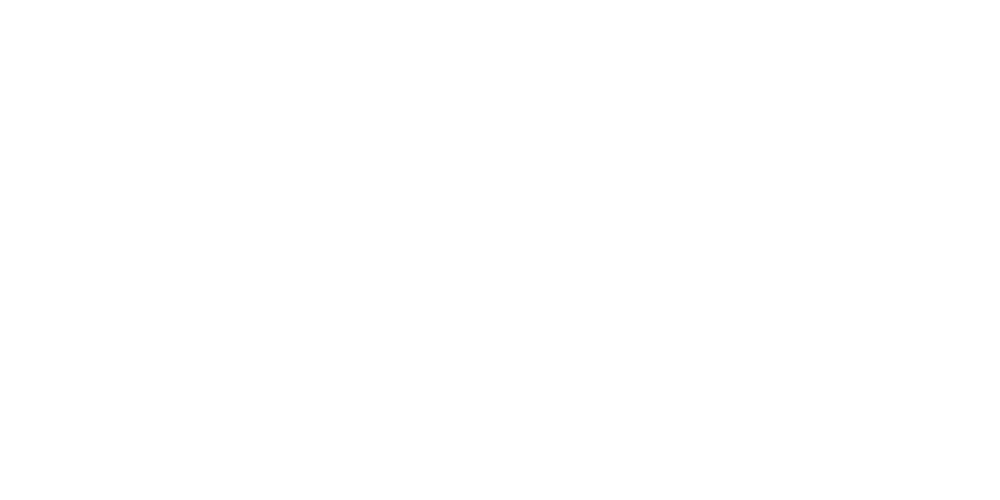

In [14]:
# Plot training history
plt.figure(figsize=(10, 5))
plt.semilogy(history['train_loss'], label='Train Loss')
plt.semilogy(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# # Hyperparameter Optimization
# def objective(trial):
#     # Suggest hyperparameters
#     hidden_size = trial.suggest_int('hidden_size', 32, 256, step = 16)
#     num_layers = trial.suggest_int('num_layers', 2, 5)
#     learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
#     dropout = trial.suggest_float('dropout', 0.1,0.5)
#     weight_decay= trial.suggest_float('weight_decay',1e-5,1e-1, log=True)
    
#     seed_len = trial.suggest_int('seed_len', 12, 128)
#     pred_len = trial.suggest_int('pred_len', 1, 20)
#     batch_size = trial.suggest_int('batch_size', 16, 64, step = 8)
    
#     train_dataset = SequenceDataset(train_scaled, seed_len=seed_len, pred_len=pred_len)
#     val_dataset = SequenceDataset(val_scaled, seed_len=seed_len, pred_len=pred_len)
    
#     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
#     val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
    
#     # Instantiate model with suggested hyperparameters
#     model = LSTMSOH(input_dim=4, hidden_dim=hidden_size, num_layers=num_layers, dropout=dropout).type(torch.float32).to(device)
#     criterion = nn.MSELoss()
#     optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay) #L2 regularization
#     history, _ = train_model(model, criterion, optimizer, train_loader, val_loader)

#     # Extract last validation loss
#     last_val_loss = history['val_loss'][-1]
#     return last_val_loss

#     # Optuna study
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=100)

# # Extract best trial
# best_trial = study.best_trial
# print(f"Best trial: {best_trial}")

# best_hyperparams = study.best_trial.params
# print('Best hyperparameters:', best_hyperparams)

In [ ]:
def evaluate_multistep(model, test_loader):
    model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for X_seed, X_future, Y_target in test_loader:
            X_seed = X_seed.to(device)        # shape: (batch_size, seed_len, 4)
            X_future = X_future.to(device)    # shape: (batch_size, pred_len, 4)
            Y_target = Y_target.to(device)    # shape: (batch_size, pred_len)
            
            batch_size, seed_len, num_features = X_seed.shape
            pred_len = Y_target.shape[1]
            
            current_seq = X_seed.clone()  # 初始输入：历史的seed数据
            preds_steps = []
            
            for t in range(pred_len):
                # 预测下一时刻目标值
                pred = model(current_seq)  # 输出 shape: (batch_size,)
                preds_steps.append(pred.unsqueeze(1))
                
                # 从X_future中获取当前时刻的外生变量（含目标列）
                next_frame = X_future[:, t, :].clone()  # shape: (batch_size, num_features)
                # 将目标位置（假设第0列）替换为预测值
                next_frame[:, 0] = pred
                # 更新输入序列：移除最早的时间步，添加新的预测帧
                current_seq = torch.cat([current_seq[:, 1:, :], next_frame.unsqueeze(1)], dim=1)
            
            preds_steps = torch.cat(preds_steps, dim=1)  # (batch_size, pred_len)
            all_preds.append(preds_steps.cpu().numpy())
            all_targets.append(Y_target.cpu().numpy())
    
    all_preds = np.concatenate(all_preds, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)
    
    r2 = r2_score(all_targets, all_preds)
    mae = mean_absolute_error(all_targets, all_preds)
    rmse = np.sqrt(mean_squared_error(all_targets, all_preds))
    
    print(f"R2:{r2:.5f} | MAE: {mae:.5e} | RMSE:{rmse:.5e}")
    
    return all_preds, all_targets, r2, mae, rmse

In [17]:
# predict_autoregressive
def evaluate_singlepass(model, df, seq_len=24):
    model.eval()
    data_array = df[['SOH_ZHU', 'Current[A]', 'Voltage[V]', 'Temperature[°C]']].values.copy()
    preds = np.full(len(data_array), np.nan)

    with torch.no_grad():
        for i in range(seq_len, len(data_array)):
            input_seq = data_array[i - seq_len : i]  # shape (seq_len, 3)
            x_t = torch.tensor(input_seq, dtype=torch.float32).unsqueeze(0).to(device)
            pred_soc = model(x_t).item()
            preds[i] = pred_soc
            # Schreibe den SOC ins "SOC-ZHU"-Feld (Spalte 2) zurück,
            # damit es beim nächsten Schritt als Input dient
            data_array[i, 0] = pred_soc
    
    return preds

model_path = r'E:\00_Thesis\04_NNs\Results\LSTM\C,V,T\02\best_model.pth'
# model_path = 'best_model.pth'
# model = LSTMSOH(input_dim=4,hidden_dim=80,num_layers=5,dropout=0.5).to(device)
# model.load_state_dict(torch.load(model_path))    
all_preds = evaluate_singlepass(model, test_scaled, seq_len=13)
all_targets = test_scaled['SOH_ZHU'].values

valid_preds = all_preds[13:]
valid_targets = all_targets[13:]   

r2 = r2_score(valid_targets, valid_preds)
mae = mean_absolute_error(valid_targets, valid_preds)
rmse = np.sqrt(mean_squared_error(valid_targets, valid_preds))
    
print(f"R2:{r2:.5f} | MAE: {mae:.5e} | RMSE:{rmse:.5e}")
    


# #Load best model   
# # model_path = r'E:\00_Thesis\04_NNs\Results\LSTM\C,V,T\00\best_model.pth'
# model_path = 'best_model.pth'
# model = LSTMSOH(input_dim=4,hidden_dim=128,num_layers=2,dropout=0.2).to(device)
# model.load_state_dict(torch.load(model_path))

# seed_len = 24
# pred_len = 1
# batch_size = 16

# test_dataset = SequenceDataset(test_scaled, seed_len=seed_len, pred_len=pred_len)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

# all_preds, all_targets, r2, mae, rmse = evaluate_model(model, test_loader)


R2:0.23443 | MAE: 2.93837e-02 | RMSE:3.50546e-02


R2:0.23443 | MAE: 2.93837e-02| RMSE:3.50546e-02


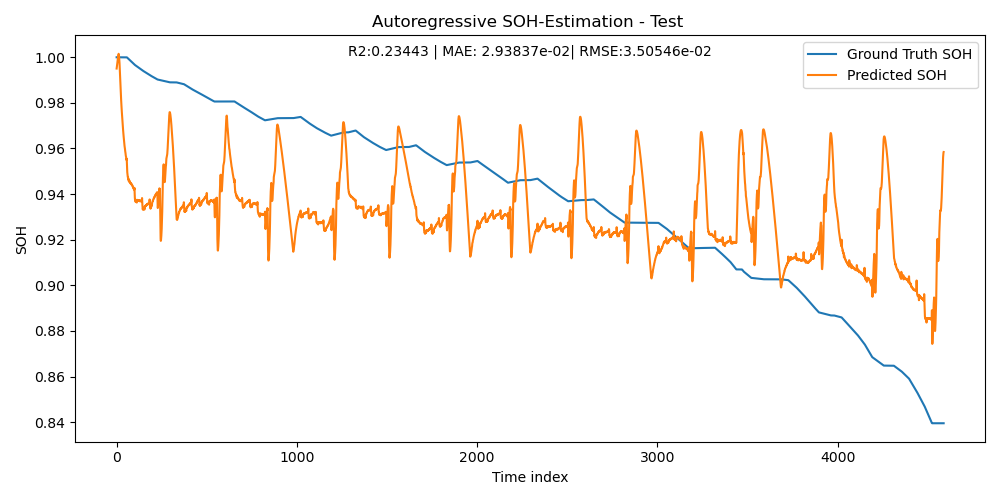

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(valid_targets, label="Ground Truth SOH")
plt.plot(valid_preds, label="Predicted SOH")
plt.title("Autoregressive SOH-Estimation - Test ")
plt.text(0.5, 0.95, f"R2:{r2:.5f} | MAE: {mae:.5e}| RMSE:{rmse:.5e}", 
         horizontalalignment='center', transform=plt.gca().transAxes)
print(f"R2:{r2:.5f} | MAE: {mae:.5e}| RMSE:{rmse:.5e}")
plt.xlabel("Time index")
plt.ylabel("SOH")
plt.legend()
plt.tight_layout()
plt.show()




In [ ]:
def autoregressive_inference(model, test_data, seed_len=13):
    """
    test_data: shape (T, num_features)
        The entire test time series in a single Tensor (or NumPy array).
    seed_len: int
        The length of the window used for the LSTM input.
    """
    model.eval()
    
    # Convert to torch.Tensor if it isn't already
    if not isinstance(test_data, torch.Tensor):
        test_data = torch.tensor(test_data, dtype=torch.float32)

    # Move to device
    test_data = test_data.to(model.device)

    T = test_data.shape[0]
    predictions = []

    # Start with the first `seed_len` steps as your 'window'
    current_seq = test_data[:seed_len].unsqueeze(0)  # shape (1, seed_len, num_features)

    # We will predict from time = seed_len to time = T-1
    # (the last possible "prediction" index)
    for t in range(seed_len, T):
        # Model expects shape (batch_size=1, sequence_length=seed_len, num_features=4)
        pred = model(current_seq)          # shape (1,) if your model outputs (batch_size,)
        pred_value = pred.item()
        
        # Store the prediction for time step t
        predictions.append(pred_value)
        
        # Create the next frame's features by copying the features from test_data[t]
        # except we replace the "SOH" column (index=0) with our predicted value
        next_frame = test_data[t].clone()  # shape (num_features,)
        next_frame[0] = pred_value
        
        # Shift the window: remove the earliest step, add this newly predicted frame
        current_seq = torch.cat([current_seq[:, 1:, :], next_frame.view(1,1,-1)], dim=1)
    
    return predictions
